# 🧠 Clasificador de Estado de Salud con PyTorch

Este proyecto utiliza una red neuronal profunda (MLP) implementada en PyTorch para clasificar el estado de salud de pacientes en tres categorías: **mala**, **regular** o **buena**, usando un conjunto de datos tabulares.

---


## Importar librerias

In [83]:
# Manejo de datos
import numpy as np
import pandas as pd
import random
import os

# Modelos de Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Gráficos
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version torch: {torch.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")
print(f"{color}- Version sklearn: {pd.__version__}")

Versión de las librerias utilizadas:
- Version torch: 2.7.1+cpu
- Version pandas: 2.2.3
- Version numpy: 2.2.6
- Version sklearn: 2.2.3


## Lectura del dataset

In [106]:
#tipo de dataset a usar
dataset_type = 'original' #original o Gen

In [114]:
try:
    # 1. Cargar el nuevo dataset multiclase
    data = pd.read_csv(f'Datasets/datasetMulti_{dataset_type}.csv') 
    print("Archivo cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

Archivo cargado correctamente.


In [115]:
data.head(5)

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [116]:
# Eliminar columnas de identificación
columns_to_drop = ['ID', 'No_Pation']
existing_columns = [col for col in columns_to_drop if col in data.columns]
if existing_columns:
    data = data.drop(columns=['ID', 'No_Pation'])

data['CLASS'] = data['CLASS'].astype(str).str.strip()
data['Gender'] = data['Gender'].astype(str).str.strip().str.upper()

# 2. Mapear la columna objetivo 'CLASS' a valores numéricos
class_mapping = {'N': 0, 'P': 1, 'Y': 2}
data['CLASS'] = data['CLASS'].map(class_mapping)

# Convertir la variable categórica 'Gender' a numérica
data = pd.get_dummies(data, columns=['Gender'], drop_first=True)

# Eliminar filas con valores nulos si los hubiera
data.dropna(inplace=True)

# Renombrar columnas para que no tengan caracteres especiales
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

print("Preprocesamiento listo. Nuevas columnas:")
print(data.columns)
data.head()
data_sample = data

Preprocesamiento listo. Nuevas columnas:
Index(['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI',
       'CLASS', 'Gender_M'],
      dtype='object')


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AGE       1000 non-null   int64  
 1   Urea      1000 non-null   float64
 2   Cr        1000 non-null   int64  
 3   HbA1c     1000 non-null   float64
 4   Chol      1000 non-null   float64
 5   TG        1000 non-null   float64
 6   HDL       1000 non-null   float64
 7   LDL       1000 non-null   float64
 8   VLDL      1000 non-null   float64
 9   BMI       1000 non-null   float64
 10  CLASS     1000 non-null   int64  
 11  Gender_M  1000 non-null   bool   
dtypes: bool(1), float64(8), int64(3)
memory usage: 87.0 KB


In [93]:
seed = 110425
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [ ]:
#Resample, solo necesario para dataset original ya que generado ya esta balanceado
class_0 = data[data['CLASS'] == 0].sample(n=53, random_state=42) 
class_1 = data[data['CLASS'] == 1].sample(n=53, random_state=42)
class_2 = data[data['CLASS'] == 2].sample(n=53, random_state=42) 
balanced_train_data = pd.concat([class_0, class_1,class_2]).sample(frac=1, random_state=42).reset_index(drop=True)
print("--- Distribución de clases en la muestra del 10% ---")
print(balanced_train_data['CLASS'].value_counts())
print("-" * 50)
data_sample = balanced_train_data

--- Distribución de clases en la muestra del 10% ---
CLASS
1.0    53
2.0    53
0.0    53
Name: count, dtype: int64
--------------------------------------------------


In [94]:
# 1. (Opcional) Tomar una muestra del 10% para pruebas rápidas
# Esto mantiene la proporción original de clases en la muestra
#data_sample['diabetes'].value_counts() para cantidad minima escribir despues
#_, data_sample, _, _ = train_test_split(balanced_train_data, balanced_train_data['diabetes'], test_size=0.10, random_state=42, stratify=data['diabetes'])


# print("--- Distribución de clases en la muestra del 10% (antes de SMOTE) ---")
# print(data_sample['diabetes'].value_counts())
# print("-" * 50)

# 2. Separar características (x) y objetivo (y) de la muestra
x = data_sample.drop(columns=["CLASS"]).to_numpy()
y = data_sample["CLASS"].to_numpy()

# 3. Dividir en conjuntos de entrenamiento, validación y prueba ANTES de SMOTE
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y) # 20% para test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train) # 15% del resto para validación

# 4. Aplicar el escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val) # Usar el mismo scaler del train
X_test = scaler.transform(X_test) # Usar el mismo scaler del train


In [95]:
#Train
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

#Val
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

#Test
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [96]:
batchsize = 32
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = DiabetesDataset(X_train, y_train)
val_data = DiabetesDataset(X_val, y_val)
test_data = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False)

In [97]:
len(train_data)

102000

In [98]:
#Definir un modelo para trabajar

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hc1 = nn.Linear(x.shape[1], 256) # Ajuste automático al número de columnas
        self.hc2 = nn.Linear(256, 128)
        self.hc3 = nn.Linear(128, 64)
        self.hc4 = nn.Linear(64, 3)
        self.act = nn.LeakyReLU()
        self.dp1 = nn.Dropout(0.4)
        self.dp2 = nn.Dropout(0.2)

    def forward(self, input):
        l1 = self.dp1(self.act(self.hc1(input)))
        l2 = self.dp2(self.act(self.hc2(l1)))
        l3 = self.act(self.hc3(l2))
        output = self.hc4(l3)
        return output

In [99]:
testeo = MLP()
lr = 1e-4
opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()


In [100]:
testeo_path = f'Guardar_modelo/MLP/Multi_{dataset_type}/Multi_{dataset_type}_pytorch.pth'
testeo_path_FULL = f'Guardar_modelo/MLP/Multi_{dataset_type}/Multi_{dataset_type}_pytorch_FULL.pth'

In [ ]:
#Cargar Pesos
testeo.load_state_dict(torch.load(testeo_path))
#Cargar Modelo
#testeo = torch.load(testeo_path_FULL)

<All keys matched successfully>

In [14]:
lambda_l1 = 1e-3
def l1_penalty(model):
    l1 = 0.0
    for param in model.parameters():
        if param.requires_grad and len(param.shape) > 1:
            l1 += torch.norm(param, p=1)
    return l1

In [ ]:
#Entrenamiento

n_epochs = 2000
history = {
    "TL" : [],
    "VL" : []
}
early_stopping = {
    "delta" : 1e-5,
    "patience": 50
}
best_val_loss = float("inf")
aux = 0

for i in range(n_epochs+1):
    testeo.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:  
      output = testeo(X_batch)
      loss = loss_func(output, y_batch)  #+ l1_penalty(testeo) *lambda_l1
      
      opt.zero_grad()
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    history["TL"].append(epoch_loss)

    testeo.eval()
    epoch_loss = 0
    for X_batch, y_batch in val_loader:
      with torch.no_grad():
        preds_val = testeo(X_batch)
      val_loss = loss_func(preds_val, y_batch)

      epoch_loss += val_loss.item()
    epoch_loss /= len(val_loader)
    history["VL"].append(epoch_loss)
    
    if epoch_loss + early_stopping["delta"] < best_val_loss:
      best_val_loss = epoch_loss
      aux = 0
    else:
      aux += 1
      if aux >= early_stopping["patience"]:
        print(f"Terminando el entrenamiento en la época {i}")
        break
    

Terminando el entrenamiento en la época 56


In [102]:
#Guardar Pesos
torch.save(testeo.state_dict(), testeo_path)
#Guardar Modelo Completo
torch.save(testeo, testeo_path_FULL)

In [118]:
#Es para usar todo el dataset de una en vez de la parte de test (No usar en expermientos)
data_sample = data
x = data_sample.drop(columns=["CLASS"]).to_numpy()
y = data_sample["CLASS"].to_numpy()

# 3. Dividir en conjuntos de entrenamiento, validación y prueba ANTES de SMOTE
X_test = x
y_test = y

# 4. Aplicar el escalado
X_test = scaler.transform(X_test) # Usar el mismo scaler del train
#Test
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

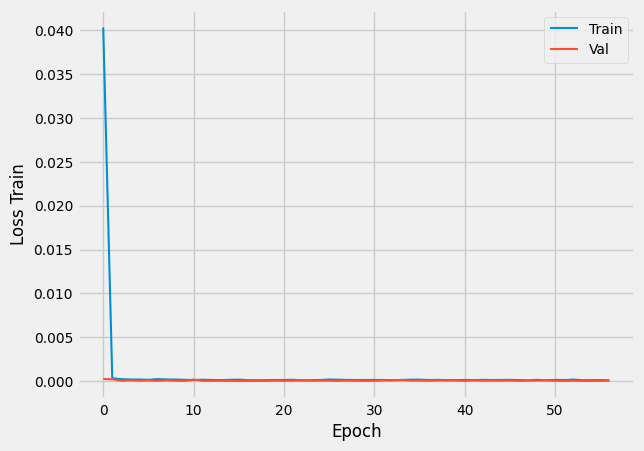

In [103]:

plt.plot(history["TL"], label="Train")
plt.plot(history["VL"], label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss Train')
plt.legend()
plt.show()

In [119]:
#Train
with torch.no_grad():
    output_train = testeo(X_train)
y_hat_train = output_train.numpy()
y_hat_train = [np.argmax(i) for i in y_hat_train]
print(f'Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}')
#Testeo
with torch.no_grad():
    output = testeo(X_test)  
y_hat = output.numpy()
y_hat = [np.argmax(i) for i in y_hat]
print(f'Testing Accuracy: {accuracy_score(y_test, y_hat):.2f}')

Training Accuracy: 1.00
Testing Accuracy: 0.70


              precision    recall  f1-score   support

           N       0.32      0.54      0.41       103
           P       0.11      0.42      0.18        53
           Y       0.99      0.74      0.84       844

    accuracy                           0.70      1000
   macro avg       0.47      0.57      0.48      1000
weighted avg       0.87      0.70      0.76      1000



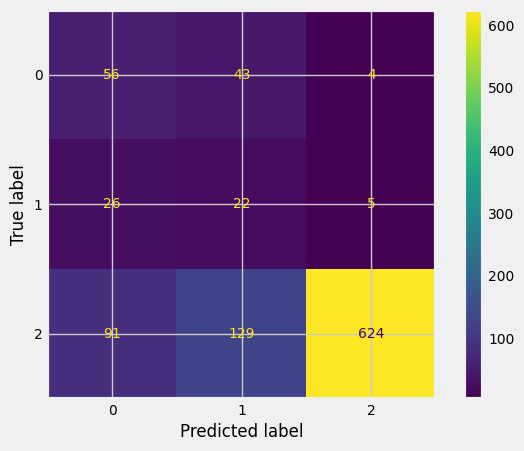

In [120]:
print(classification_report(y_test, y_hat, target_names=['N', 'P', 'Y']))
cm =confusion_matrix(y_test, y_hat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
plt.show()